In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import time

from scipy.stats import sem
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset
from torchmetrics import Accuracy
from torchvision.transforms import v2
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision as tv

#from vit_pytorch import *


import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar, EarlyStopping, StochasticWeightAveraging,LearningRateFinder, Timer
from pytorch_lightning.loggers import CSVLogger

from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import timm


%matplotlib inline 



torch.manual_seed(21)
np.random.seed(21)
random.seed(21)

In [3]:
url_images = []
for (root,dirs,files) in os.walk('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'):
    for dir_ in dirs:
        cell_data = os.path.join('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset', dir_)
        for (root,dirs,files) in os.walk(cell_data):
            new_files = ['/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/' + dir_ + "/" + file_name for file_name in files]
            url_images += (new_files)

In [4]:
from sklearn.model_selection import StratifiedKFold

class BloodData(Dataset):
    def __init__(self, url_images, k_folds=5, fold=0, use="train", augment=False, reshape=True):
        self.url_images = url_images
        
        self.target_mappings = {
            "basophil": 0,
            "eosinophil": 1,
            "erythroblast": 2,
            "ig": 3,
            "lymphocyte": 4,
            "monocyte": 5,
            "neutrophil": 6,
            "platelet": 7,
        }
        
        self.targets = np.array([self.target_mappings[url.split("/")[5]] for url in self.url_images])
        self.augment = augment
        self.reshape = reshape
        self.use = use
        if self.use == "test":
            self.indices = np.arange(len(self.url_images))
        else:
            self.k_folds = k_folds
            self.fold = fold
            self.kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=21)


            all_indices = np.arange(len(url_images))
            train_indices, valid_indices = list(self.kf.split(self.url_images, self.targets))[fold]
            if use=='train':
                self.indices = train_indices
            else:
                self.indices = valid_indices

        
        self.reshape = v2.Compose([
            v2.ToPILImage(),
            v2.Resize(size=(360,360)),
            #v2.Resize(size=(224,224)),
            v2.ToTensor(),
        ])
        
        self.transform_train = v2.Compose([
            v2.ToPILImage(),
            v2.RandomAffine(degrees=360, translate=(0.15,0.15), shear=15),
            v2.ColorJitter(brightness=0.25,hue=0.1,contrast=0.1,saturation=0.1),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        array = np.asarray(mpimg.imread(self.url_images[idx]))
        array = self._augment(array)
        return  torch.Tensor(array) / 255, self.targets[idx]

    def _augment(self, img):
        if self.use=='train' or self.augment==True:
            img = self.transform_train(img)
        if self.reshape:
            img = self.reshape(img)
        return img
    
    def change_fold(self, new_fold):
        self.fold = new_fold
        train_indices, valid_indices = list(self.kf.split(self.url_images))[new_fold]
        if self.train:
            self.indices = train_indices
        else:
            self.indices = valid_indices

In [5]:
print(len(BloodData(url_images,use="train")))
print(len(BloodData(url_images,use="val")))
print(len(BloodData(url_images,use="test")))

13673
3419
17092


In [6]:
class BloodClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = tv.models.mobilenet_v3_large(weights=tv.models.MobileNet_V3_Large_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, 8)
        self.lr = 5e-4
        self.inference_time = 0
        self.inference_data = 0
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        device = x.get_device()
        pred = self.model(x)
        loss = torch.nn.CrossEntropyLoss()(pred, y)
        self.log("train_loss", loss, True, True)
        self.log("train_accuracy", Accuracy(task="multiclass", num_classes=8).to(device)(pred,y), True, True)
        return loss
        
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        self.inference_data += x.shape[0]
        device = x.get_device()
        start_time = time.time()
        pred = self.model(x)
        self.inference_time += (time.time() - start_time)
        loss = F.cross_entropy(pred, y)
        self.log("val_loss", loss, True, True)
        self.log("val_accuracy", Accuracy(task="multiclass", num_classes=8).to(device)(pred,y), True, True)
        
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [7]:
model = BloodClassifier()
print(sum(p.numel() for p in model.parameters()))
del model

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 130MB/s] 


4212280


In [8]:
target_mappings = {
    "basophil": 0,
    "eosinophil": 1,
    "erythroblast": 2,
    "ig": 3,
    "lymphocyte": 4,
    "monocyte": 5,
    "neutrophil": 6,
    "platelet": 7,
}

labels = list(target_mappings.keys())

def plot_confusion_matrix(ax, true, pred, title):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

In [9]:
def run_training(fold):
    print('================================================================')
    print(f"==== Running training for fold {fold} ====")
    train_ds = BloodData(url_images, k_folds=5, fold=fold)
    val_ds = BloodData(url_images, k_folds=5, fold=fold, use="val")
    print(f'Train Samples: {len(train_ds)}')
    print(f'Valid Samples: {len(val_ds)}')

    y = train_ds.targets[train_ds.indices]
    counts = np.bincount(y)
    labels_weights = 1. / counts
    weights = labels_weights[y]
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=64,
        num_workers=2,
        persistent_workers=True,
        pin_memory=True,
        sampler=WeightedRandomSampler(weights, len(weights))
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        persistent_workers=True,
        pin_memory=True
    )
    
    # == init model ==
    model = BloodClassifier()
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_accuracy',
                                          dirpath="/kaggle/working",
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold}",
                                          mode='max')
    
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1), 
                       EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=25, verbose=False, mode="max")]

    trainer = pl.Trainer(
        max_epochs=15,
        val_check_interval=0.15,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="auto",
        deterministic=True,
        precision='16-mixed',
        accumulate_grad_batches=32,
        logger=CSVLogger(f"logs_{fold}", name="logger"),
        log_every_n_steps=1
    )
    
    
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    print("Inference datapoints ran:",model.inference_data)
    print("Inference time ran:",model.inference_time)
    ips = model.inference_data/model.inference_time
    print("Inferences per second:", ips)
    
    
    training = pd.read_csv(f'/kaggle/working/logs_{fold}/logger/version_0/metrics.csv')
    df_melted_cleaned = pd.melt(training, id_vars=['epoch', 'step'], var_name='metric', value_name='value').dropna()
    accuracy_df_train = df_melted_cleaned[(df_melted_cleaned['metric'].str.contains('train_accuracy'))]
    accuracy_df_val = df_melted_cleaned[(df_melted_cleaned['metric'].str.contains('val_accuracy'))]
    loss_df_train = df_melted_cleaned[(df_melted_cleaned['metric'].str.contains('train_loss'))]
    loss_df_val = df_melted_cleaned[(df_melted_cleaned['metric'].str.contains('val_loss'))]
    colors = sns.color_palette("Set2", 4)
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot loss
    sns.lineplot(data=loss_df_train, x='step', y='value', color=colors[0], label='Train Loss', ax=axs[0])
    sns.lineplot(data=loss_df_val, x='step', y='value', color=colors[1], label='Val Loss', ax=axs[0])
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Step')
    axs[0].set_title('Loss Metrics')
    axs[0].legend(loc='best')

    # Plot accuracy
    sns.lineplot(data=accuracy_df_train, x='step', y='value', color=colors[2], label='Train Accuracy', ax=axs[1])
    sns.lineplot(data=accuracy_df_val, x='step', y='value', color=colors[3], label='Val Accuracy', ax=axs[1])
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].set_xlabel('Step')
    axs[1].set_title('Accuracy Metrics')
    axs[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Val loss for {fold}: ", accuracy_df_val.loc[accuracy_df_val['value'].idxmax()])
    

    with torch.no_grad():
        torch.cuda.empty_cache()
    model = BloodClassifier.load_from_checkpoint(f'/kaggle/working/fold_{fold}.ckpt').model
    model.eval()
    pred_validation = []
    true_validation = []
    for x, y in val_ds:
        with torch.no_grad():
            pred_validation.append(torch.argmax(model(x[None].to('cuda')), dim=-1).cpu().numpy().item())
        true_validation.append(y)
        
    plt.tight_layout()
    plt.show()
    
    return pred_validation, true_validation, ips

==== Running training for fold 0 ====
Train Samples: 13673
Valid Samples: 3419


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Inference datapoints ran: 307838
Inference time ran: 88.42815661430359
Inferences per second: 3481.221499874691


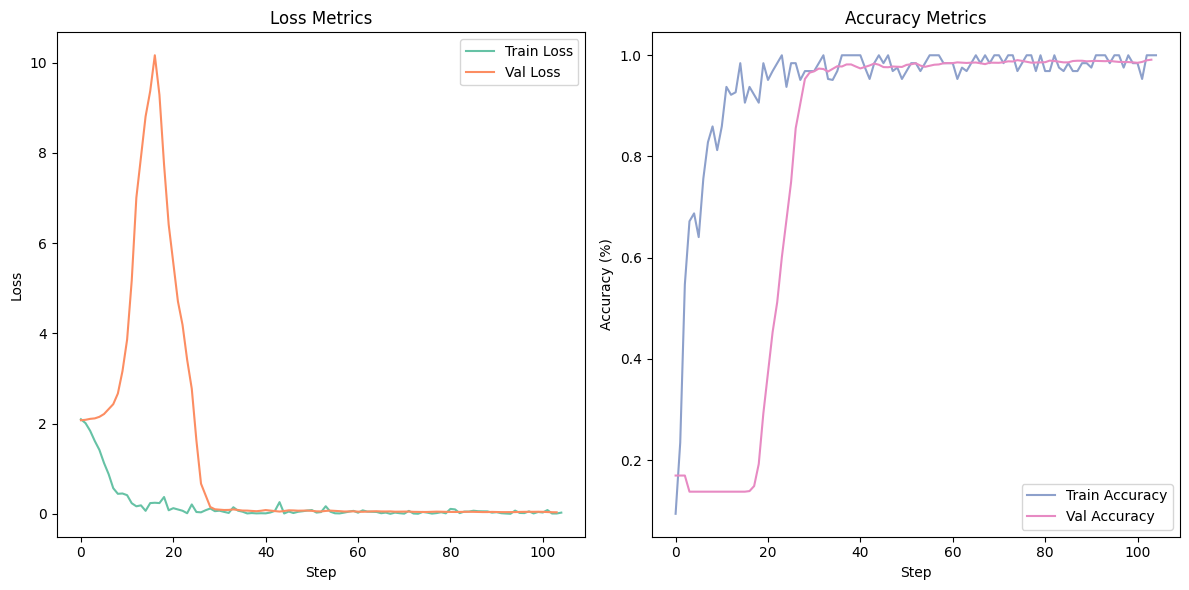

Val loss for 0:  epoch               14
step               103
metric    val_accuracy
value         0.991225
Name: 583, dtype: object


<Figure size 640x480 with 0 Axes>

==== Running training for fold 1 ====
Train Samples: 13673
Valid Samples: 3419


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Inference datapoints ran: 263391
Inference time ran: 73.96832394599915
Inferences per second: 3560.8620818864247


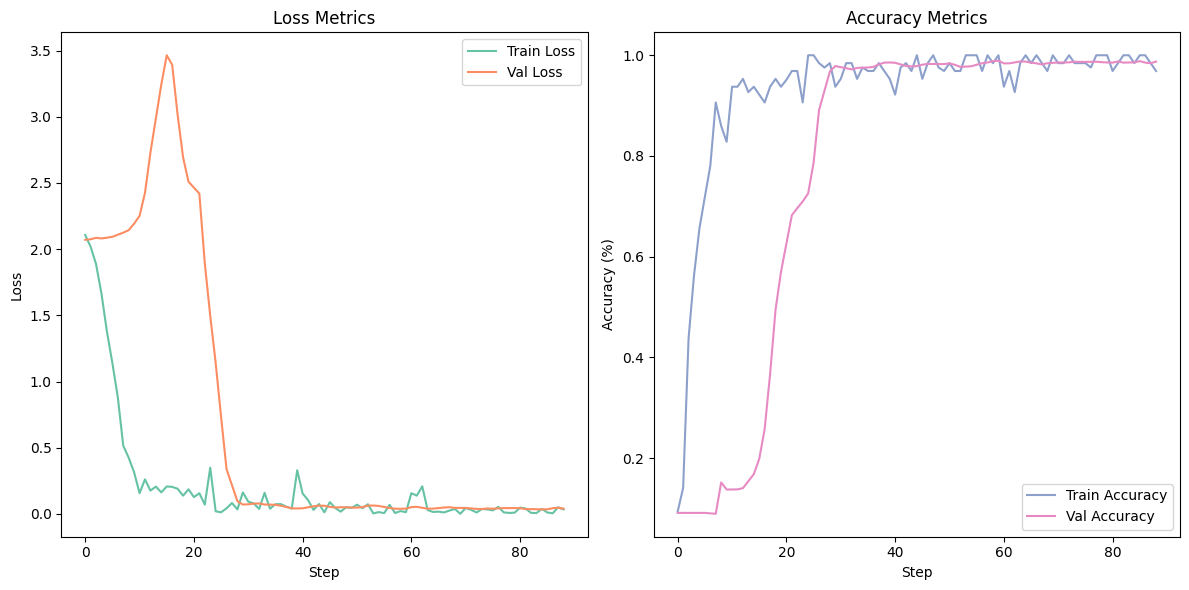

Val loss for 1:  epoch                8
step                59
metric    val_accuracy
value         0.989178
Name: 443, dtype: object


<Figure size 640x480 with 0 Axes>

==== Running training for fold 2 ====
Train Samples: 13674
Valid Samples: 3418


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Inference datapoints ran: 307748
Inference time ran: 87.06076502799988
Inferences per second: 3534.8644122415444


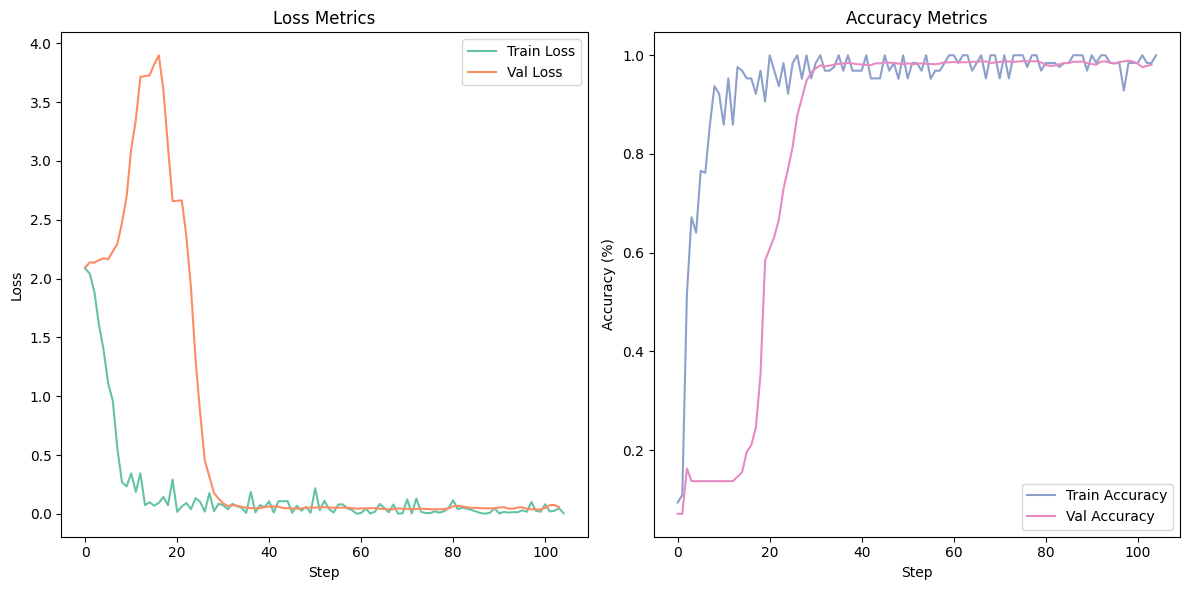

Val loss for 2:  epoch               14
step                98
metric    val_accuracy
value         0.988882
Name: 573, dtype: object


<Figure size 640x480 with 0 Axes>

==== Running training for fold 3 ====
Train Samples: 13674
Valid Samples: 3418


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Inference datapoints ran: 290658
Inference time ran: 81.39393091201782
Inferences per second: 3571.003350534632


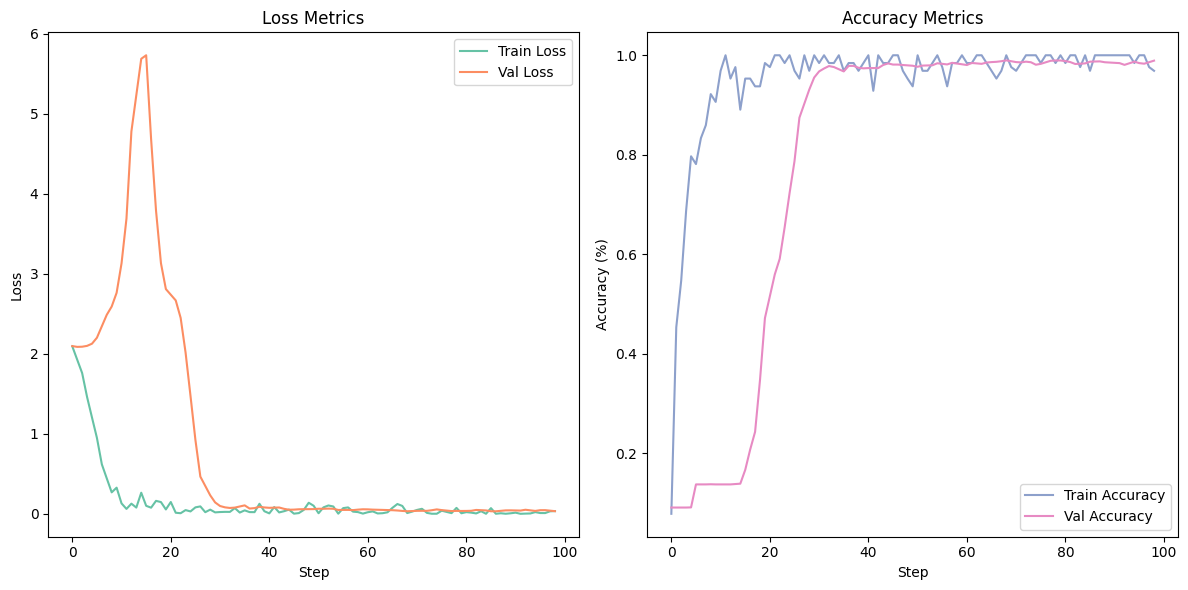

Val loss for 3:  epoch                9
step                68
metric    val_accuracy
value          0.98976
Name: 496, dtype: object


<Figure size 640x480 with 0 Axes>

==== Running training for fold 4 ====
Train Samples: 13674
Valid Samples: 3418


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Inference datapoints ran: 307748
Inference time ran: 85.37312173843384
Inferences per second: 3604.741091029543


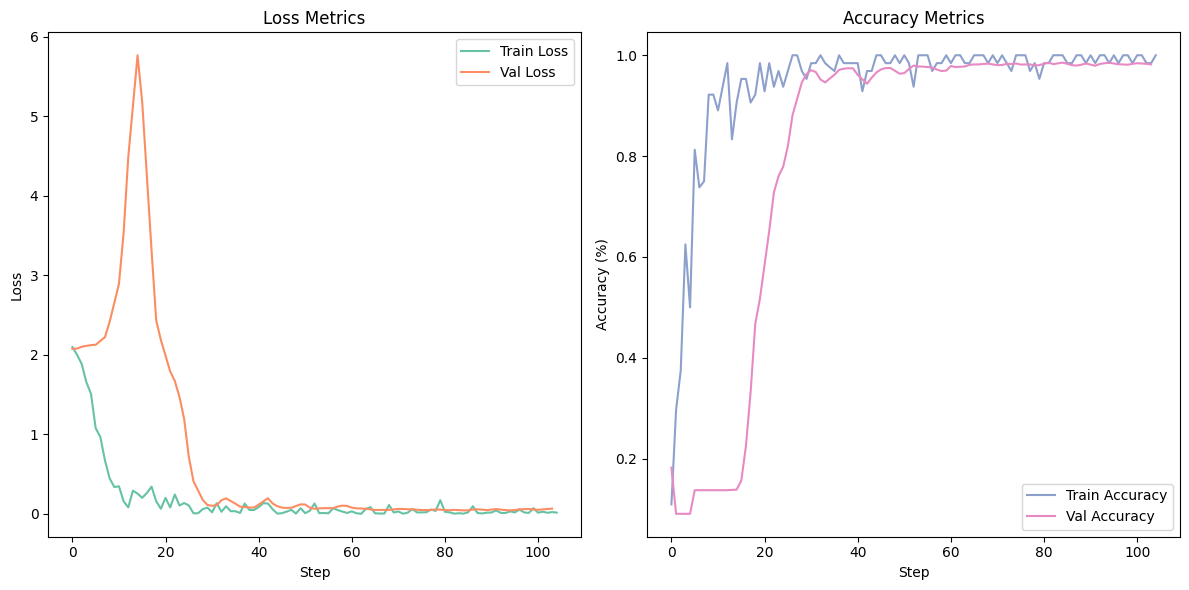

Val loss for 4:  epoch               11
step                81
metric    val_accuracy
value         0.985372
Name: 542, dtype: object


<Figure size 640x480 with 0 Axes>




Final Accuracy:  0.9888252019882202
Average Inference speed:  3550.538487113367


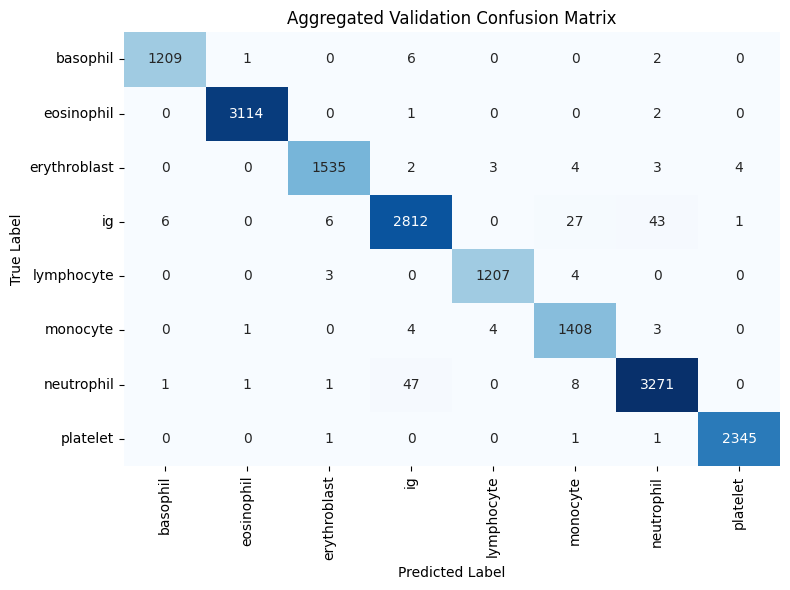

              basophil   eosinophil  erythroblast           ig   lymphocyte  \
precision     0.994243     0.999038      0.992885     0.979109     0.994234   
recall        0.992611     0.999038      0.989684     0.971330     0.994234   
f1-score      0.993426     0.999038      0.991282     0.975204     0.994234   
support    1218.000000  3117.000000   1551.000000  2895.000000  1214.000000   

              monocyte   neutrophil     platelet  accuracy     macro avg  \
precision     0.969697     0.983759     0.997872  0.988825      0.988855   
recall        0.991549     0.982577     0.998722  0.988825      0.989968   
f1-score      0.980501     0.983168     0.998297  0.988825      0.989394   
support    1420.000000  3329.000000  2348.000000  0.988825  17092.000000   

           weighted avg  
precision      0.988847  
recall         0.988825  
f1-score       0.988823  
support    17092.000000   


\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & basophil & eosinophil & erythroblast & ig & lymp

In [10]:
preds = []
trues = []
average_speed = 0

for i in range(5):
    pred, true, speed = run_training(i)
    preds += pred
    trues += true
    average_speed += speed
average_speed /= 5
print("\n\n")
    
print("Final Accuracy: ", Accuracy(task="multiclass", num_classes=8)(torch.Tensor(preds), torch.Tensor(trues)).item())
print("Average Inference speed: ", average_speed)

fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(ax, trues, preds, 'Aggregated Validation Confusion Matrix')
plt.tight_layout()
plt.show()

report = classification_report(trues, preds, output_dict = True, target_names=labels)

print(pd.DataFrame(report), "\n\n")

print(pd.DataFrame(report).to_latex(), "\n\n")